# U-Net Model

In [ ]:
# Mounting Google Drive to get the dataset from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
# Importing necessary libraries for data manipulation, model, visualization and metrics
import tensorflow as tf
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *

## Loading and preparing the data

In [ ]:
from glob import glob

# Path to where your dataset is stored in Colab
paths = glob('/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/*/*')

# Printing the details regarding the dataset
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")



'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [ ]:
# Retrieve a sorted list of file paths from a specified directory and then select a slice of that list
sorted(glob('/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    # Changing the shape of image from (size,size,3) to (size,size,1)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Normalization
    image = image/255.   
    return image

def load_data(root_path, size):
    images = []
    masks = []
    # Using below variable to identify image that consists of two or more masks
    x = 0   
    for path in sorted(glob(root_path)):
        img = load_image(path, size) 
        if 'mask' in path:
            # If image has masks more than one add the mask to the last mask
            if x:   
                masks[-1] += img   
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1
        else:
            images.append(img)
            x = 0 
    return np.array(images), np.array(masks)

In [ ]:
# Calling function load_data to process data from a specified path and resize the images to a certain size
size = 128   
X, y = load_data('/content/drive/MyDrive/Breast Cancer/Dataset_BUSI_with_GT/*/*', size=size)


## Exploring the data

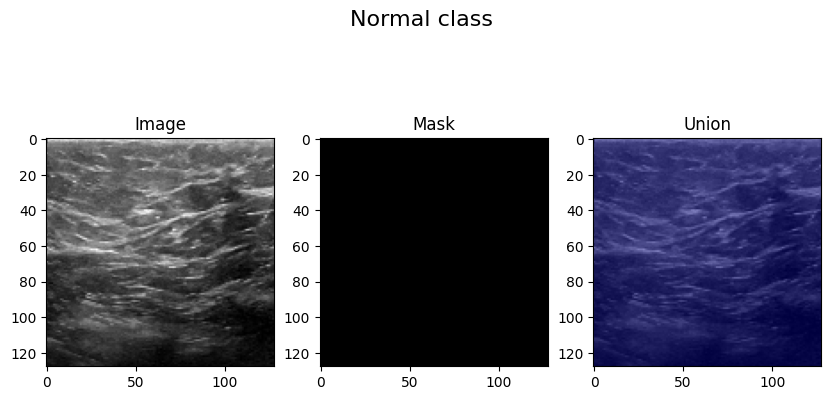

In [ ]:
# The first 437 samples (X[0:437]) correspond to benign cases.
# Samples from 437 to 647 (X[437:647]) correspond to malignant cases.
# Samples from 647 to 780 (X[647:780]) correspond to normal cases.
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

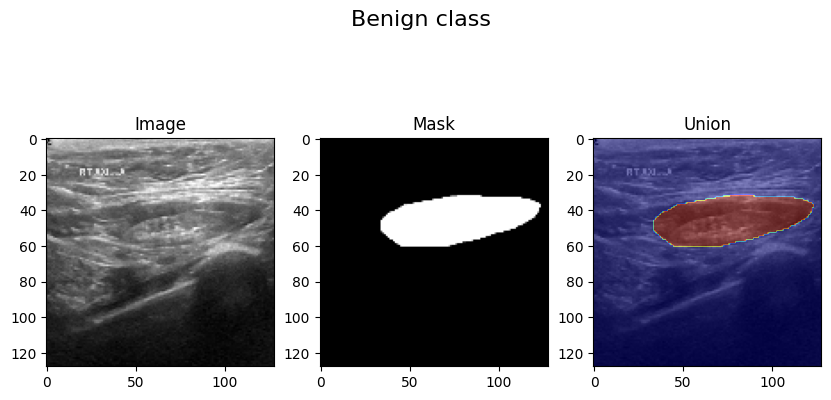

In [ ]:
# The first 437 samples (X[0:437]) correspond to benign cases.
# Samples from 437 to 647 (X[437:647]) correspond to malignant cases.
# Samples from 647 to 780 (X[647:780]) correspond to normal cases.
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

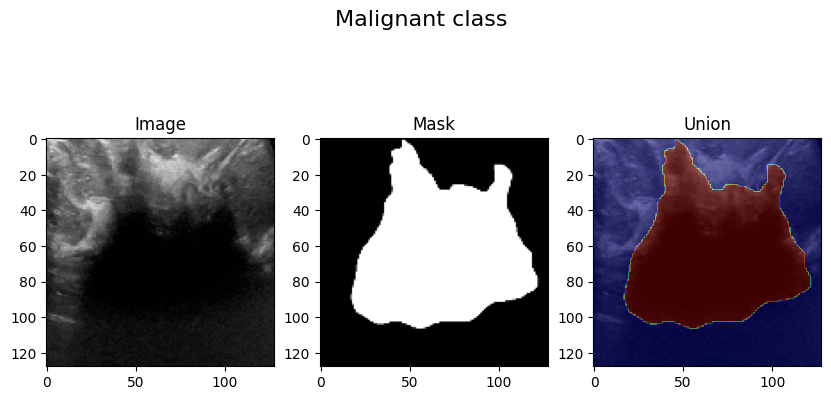

In [ ]:
# The first 437 samples (X[0:437]) correspond to benign cases.
# Samples from 437 to 647 (X[437:647]) correspond to malignant cases.
# Samples from 647 to 780 (X[647:780]) correspond to normal cases.
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

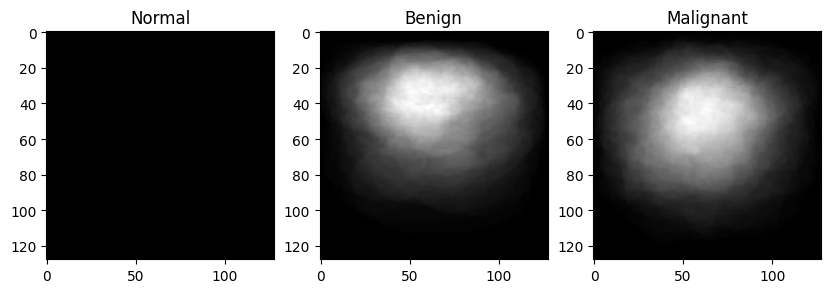

In [ ]:
# The first 437 samples (X[0:437]) correspond to benign cases.
# Samples from 437 to 647 (X[437:647]) correspond to malignant cases.
# Samples from 647 to 780 (X[647:780]) correspond to normal cases.
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

In [ ]:
# Dropping the normal class as normal class does not have masks
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


## Splitting the data

In [ ]:
# Printing the shapes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


## U-Net Model

### Convolutional Block

In [ ]:
# Convolutional Block
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### Encoder Block

In [ ]:
# Encoder Block
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### Decoder Block

In [ ]:
# Decoder Block
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

### Complete U-Net Model

In [ ]:
# Complete UNet model
def build_model(input_shape):
    input_layer = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

# Building the model using binary cross entropy and optimizing it using Adam
model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [23]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Model Training

In [ ]:
# Training the model with 100 epochs
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 [==============================] - 89s 4s/step - loss: 0.7504 - accuracy: 0.8531 - val_loss: 0.3512 - val_accuracy: 0.9024
Epoch 2/100
19/19 [==============================] - 84s 4s/step - loss: 0.3504 - accuracy: 0.9046 - val_loss: 0.3605 - val_accuracy: 0.9024
Epoch 3/100
19/19 [==============================] - 83s 4s/step - loss: 0.3110 - accuracy: 0.9018 - val_loss: 0.2803 - val_accuracy: 0.9024
Epoch 4/100
19/19 [==============================] - 84s 4s/step - loss: 0.4118 - accuracy: 0.8908 - val_loss: 0.3684 - val_accuracy: 0.9024
Epoch 5/100
19/19 [==============================] - 83s 4s/step - loss: 0.3968 - accuracy: 0.8825 - val_loss: 0.3414 - val_accuracy: 0.9024
Epoch 6/100
19/19 [==============================] - 83s 4s/step - loss: 0.3176 - accuracy: 0.9046 - val_loss: 0.3173 - val_accuracy: 0.9024
Epoch 7/100
19/19 [==============================] - 83s 4s/step - loss: 0.2946 - accuracy: 0.9046 - val_loss: 0.2665 - val_accuracy: 0.9024
Epoch 8/100
1

### Loss and Accuracy

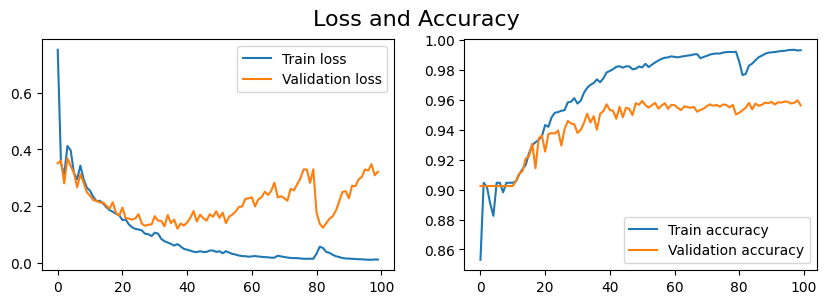

In [ ]:
# Plot the loss and accuracy for train and validation data
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

## Evaluating the model - Visualization of predictions

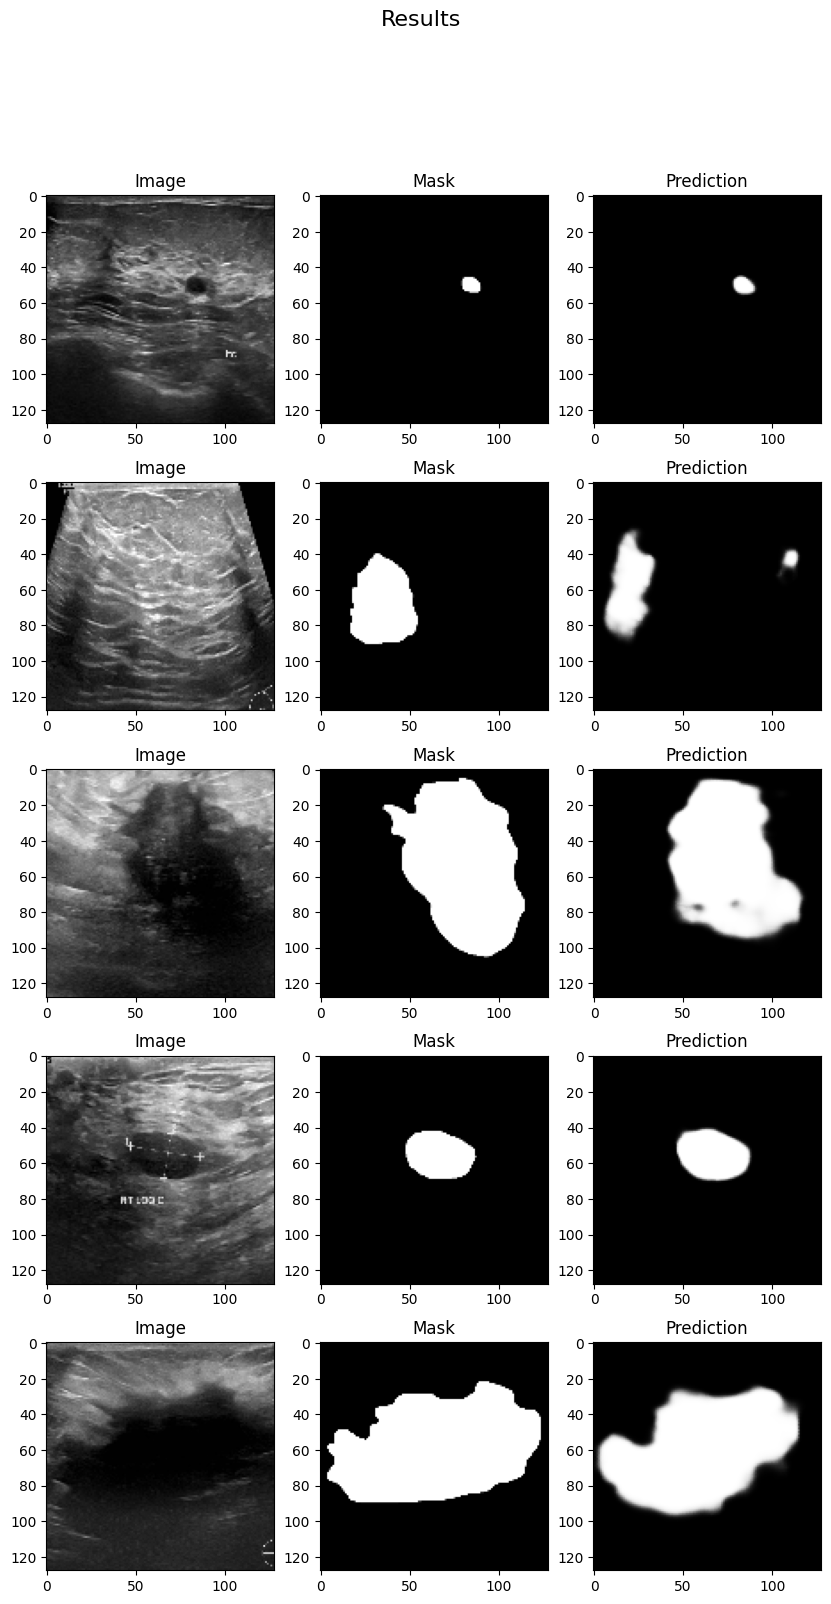

In [ ]:
# Evaluating the model
fig, ax = plt.subplots(5,3, figsize=(10,18))
j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results showing Image, Mask and Prediction', fontsize=16)
plt.show()

In [ ]:
# Calculating metrics Mean Intersection-Over-Union metric, Precision, Recall, F1 score
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# Calculating F1 score
f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

# Calculating mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

# Calculating Recall
recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)


# Calculating Precision
prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

Mean IoU = 0.7963537
Precision Score = 0.777
Recall Score = 0.783
F1 Score = 0.780
